In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk import word_tokenize, ngrams
from sklearn import ensemble
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
import xgboost

eng_stopword = set(stopwords.words('english'))
color = sns.color_palette()
plt.style.use('ggplot')

%matplotlib inline
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings('ignore')

### 1.1读取数据

In [2]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
print(train_df.shape)
print(test_df.shape)

(404290, 6)
(2345796, 3)


In [3]:
display(train_df.head())

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


train_df文件包含404290条数据，每条数据包含6个特征，其中qid1和qid2是问题句子的唯一id，question1和question2是id对于的句子内容，is_duplicate则是判断这两个句子是不是同一个含义。test_df有2345796条样本，远比训练集要多，这是因为平台为了反作弊，人工造了很多随机的句子。

In [4]:
test_df.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


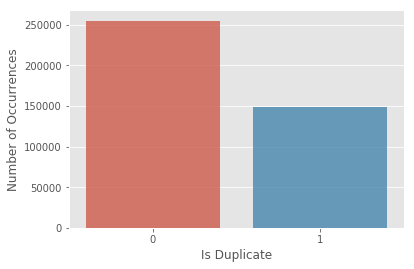

In [5]:
is_dup = train_df['is_duplicate'].value_counts()

plt.figure()
sns.barplot(is_dup.index,is_dup.values,alpha=0.8)
plt.ylabel('Number of Occurrences',fontsize=12)
plt.xlabel('Is Duplicate',fontsize=12)
plt.show()

In [6]:
is_dup / is_dup.sum()

0    0.630802
1    0.369198
Name: is_duplicate, dtype: float64

分类样本有一定程度的不平衡，标记为0的大概是标记为1的1.7倍。下面，我们将所有的训练集中的句子组合在一起讨论。

In [7]:
all_ques_df = pd.DataFrame(pd.concat([train_df['question1'],train_df['question2']]))
all_ques_df.columns = ['questions']

all_ques_df['num_of_words'] = all_ques_df['questions'].apply(lambda x: len(str(x).split()))

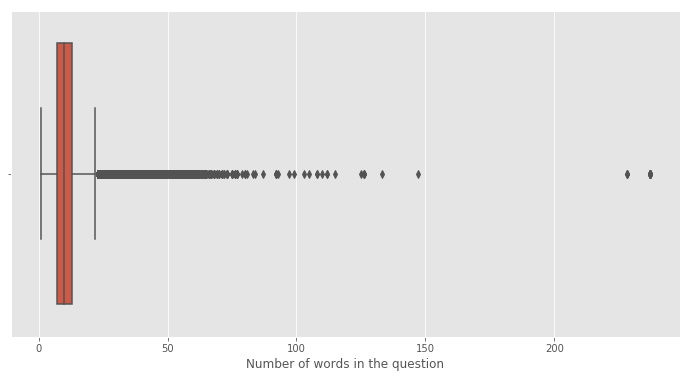

In [8]:
plt.figure(figsize=(12,6))
sns.boxplot(all_ques_df['num_of_words'])
plt.xlabel('Number of words in the question',fontsize=12)
plt.show()

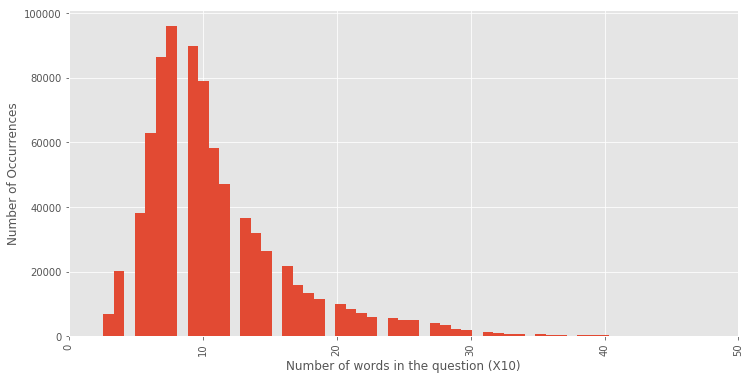

In [9]:
cnt_srs = all_ques_df['num_of_words'].value_counts()

plt.figure(figsize=(12,6))
plt.hist(all_ques_df['num_of_words'],bins=300)
plt.ylabel('Number of Occurrences',fontsize=12)
plt.xlabel('Number of words in the question (X10)',fontsize=12)
plt.xticks(rotation=90)
plt.xlim([0,50])
plt.show()

训练集中的问题句子长度分布如上图所示，每个句子包含的单词数量从0到200分布，主要的分布集中在0-30个单词。
下面将定义几个函数，其中get_unigrams是将每个句子去掉停顿词；get_common_unigrams返回同时出现在question1和question2的单词有几个；get_common_unigram_ratio返回question1和question2中单词的交集长度与并集长度的比值，反应两个句子重复单词的比例。

In [10]:
def get_unigrams(que):
    sequence = [word for word in word_tokenize(que.lower()) 
                if not word in eng_stopword]
    return sequence

def get_common_unigrams(row):
    return len(set(row['unigrams_ques1']).intersection(set(row['unigrams_ques2'])))

def get_common_unigram_ratio(row):
    return float(row['unigrams_common_count'])/max(len(set(row['unigrams_ques1']).union(set(row['unigrams_ques2']))),1)

train_df['unigrams_ques1'] = train_df['question1'].apply(lambda x:get_unigrams(str(x)))
train_df['unigrams_ques2'] = train_df['question2'].apply(lambda x:get_unigrams(str(x)))
train_df['unigrams_common_count'] = train_df.apply(lambda row:get_common_unigrams(row),axis=1)
train_df['unigrams_common_ratio'] = train_df.apply(lambda row:get_common_unigram_ratio(row),axis=1)

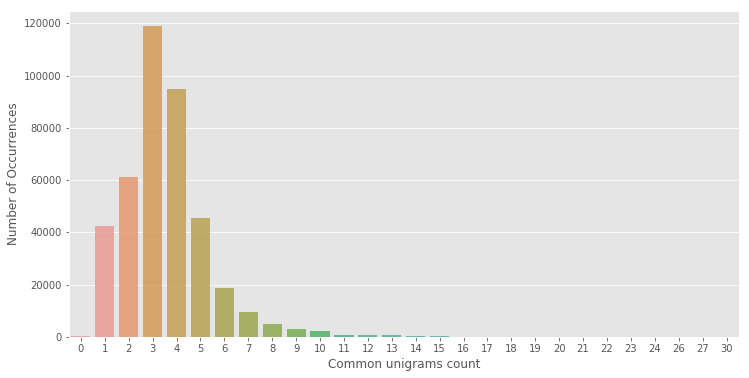

In [11]:
cnt_srs = train_df['unigrams_common_count'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index,cnt_srs.values,alpha=0.8)
plt.ylabel('Number of Occurrences',fontsize=12)
plt.xlabel('Common unigrams count',fontsize=12)
plt.show()

从上图可以发现，句子去除停顿词后，两个句子的重复单词数量，大多数的句子对仅有1-6个单词是重复的。

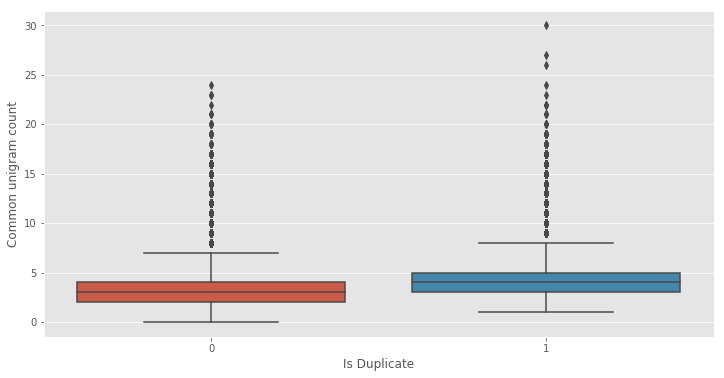

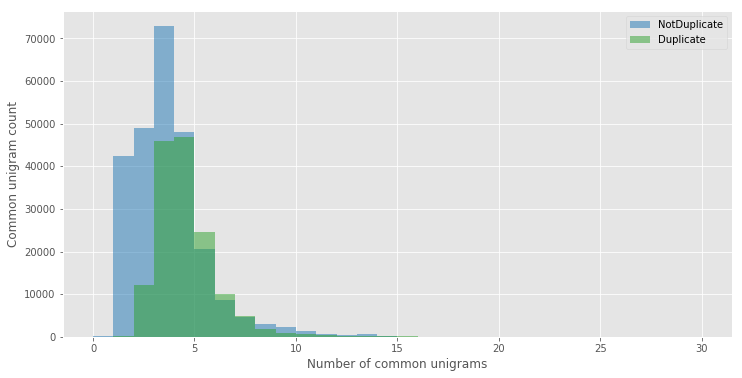

In [12]:
plt.figure(figsize=(12,6))
sns.boxplot(data=train_df,x='is_duplicate',y='unigrams_common_count')
plt.xlabel('Is Duplicate',fontsize=12)
plt.ylabel('Common unigram count',fontsize=12)
plt.show()

plt.figure(figsize=(12,6))
plt.hist(train_df[train_df['is_duplicate']==0]['unigrams_common_count'],bins=30,range=[0,30],color=color[0],alpha=0.5,label='NotDuplicate')
plt.hist(train_df[train_df['is_duplicate']==1]['unigrams_common_count'],bins=30,range=[0,30],color=color[2],alpha=0.5,label='Duplicate')
plt.xlabel('Number of common unigrams')
plt.ylabel('Common unigram count',fontsize=12)
plt.legend()
plt.show()

从分布上看，如果两个句子是同一个含义，那么句子对之间重复的单词数量会比他们不是同一个含义的要多些。

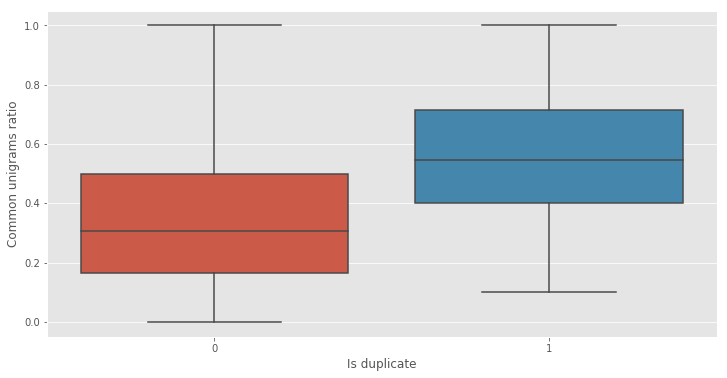

In [13]:
plt.figure(figsize=(12,6))
sns.boxplot(data=train_df,x='is_duplicate',y='unigrams_common_ratio')
plt.xlabel('Is duplicate',fontsize=12)
plt.ylabel('Common unigrams ratio',fontsize=12)
plt.show()

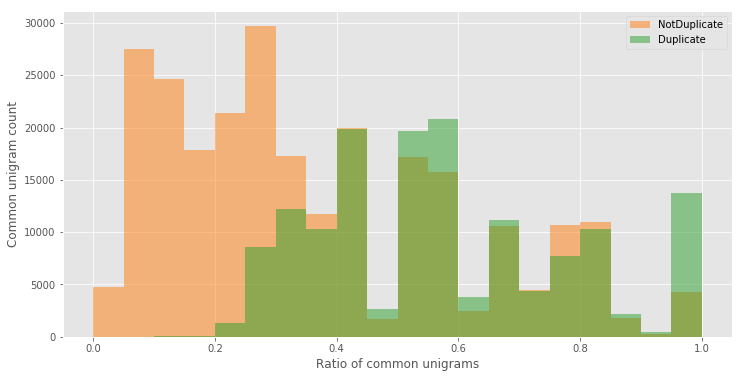

In [14]:
plt.figure(figsize=(12,6))
plt.hist(train_df[train_df['is_duplicate']==0]['unigrams_common_ratio'],bins=20,range=[0,1],color=color[1],label='NotDuplicate',alpha=0.5)
plt.hist(train_df[train_df['is_duplicate']==1]['unigrams_common_ratio'],bins=20,range=[0,1],color=color[2],label='Duplicate',alpha=0.5)
plt.xlabel('Ratio of common unigrams')
plt.ylabel('Common unigram count',fontsize=12)
plt.legend()
plt.show()

从重复比例上看，这个情况就更加明显了，两个句子唯一单词的重复比例较低的时候(0-0.2)，大部分的时候可以判定这两个句子就不是在描述同一个含义；但这个重复比例逐渐上升，两个句子是同一个含义的可能性也在不断提高。

### Leaky features exploration

- 1 Frequency based feature by [Jared Turkewitz](https://www.kaggle.com/jturkewitz/magic-features-0-03-gain)

- 2 Intersection of common neighbors by [Krzysztof Dziedzic](https://www.kaggle.com/tour1st/magic-feature-v2-0-045-gain) inplemented by tour1st

这里有一个非常有用的泄露特征，是上面链接中的作者发现的，我仅在这里用python的工具再重现一下。

In [15]:
ques = pd.concat([train_df[['question1','question2']],test_df[['question1','question2']]],axis=0).reset_index(drop='index')
ques.shape

(2750086, 2)

新建默认字典，字典的key为question1和question2的句子，value是与key成对出现在训练集中的那些句子的集合。

In [16]:
from collections import defaultdict
q_dict = defaultdict(set)

for i in range(ques.shape[0]):
    q_dict[ques.question1[i]].add(ques.question2[i])
    q_dict[ques.question2[i]].add(ques.question1[i])

* q1_freq统计的是与question1中句子成对出现在训练集中的question2的句子样本有多少条；
* q2_freq统计的是与question2中句子成对出现在训练集中的question1的句子样本有多少条；
* q1_q2_intersect统计的是与question1中句子成对出现在训练集中的question2的句子样本set1，与question2中句子成对出现在训练集中的question1的句子样本set2，set1与set2的交集有多少条。

In [17]:
def q1_freq(row):
    return (len(q_dict[row['question1']]))
def q2_freq(row):
    return (len(q_dict[row['question2']]))

def q1_q2_intersect(row):
    return (len(set(q_dict[row['question1']]).intersection(set(q_dict[row['question2']]))))

In [18]:
train_df['q1_q2_intersect'] = train_df.apply(q1_q2_intersect,axis=1,raw=True)
train_df['q1_freq'] = train_df.apply(q1_freq,axis=1,raw=True)
train_df['q2_freq'] = train_df.apply(q2_freq,axis=1,raw=True)

### Q1-Q2 neighbor intersection count

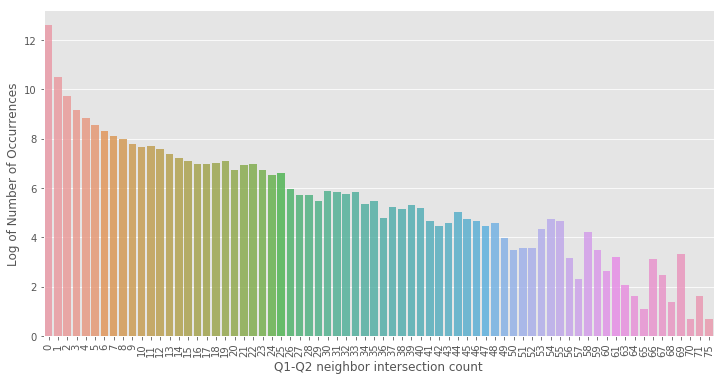

In [19]:
cnt_srs = train_df['q1_q2_intersect'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index,np.log1p(cnt_srs.values),alpha=0.8)
plt.xlabel('Q1-Q2 neighbor intersection count',fontsize=12)
plt.ylabel('Log of Number of Occurrences',fontsize=12)
plt.xticks(rotation=90)
plt.show()

q1_q2_intersect交集结果分布如上图，纵坐标为对数结果。分布上看，还是有很多句子是仅有一次检索的。

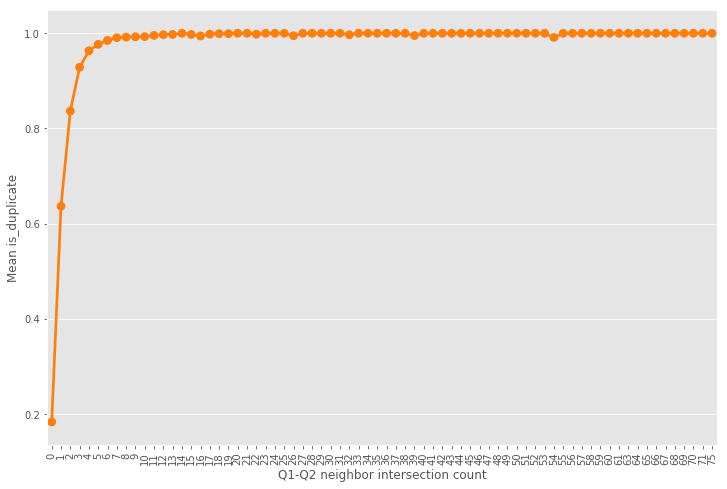

In [20]:
grouped_df = train_df.groupby('q1_q2_intersect')['is_duplicate'].aggregate('mean').reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['q1_q2_intersect'].values,grouped_df['is_duplicate'].values,alpha=0.8,color=color[1])
plt.ylabel('Mean is_duplicate',fontsize=12)
plt.xlabel('Q1-Q2 neighbor intersection count',fontsize=12)
plt.xticks(rotation=90)
plt.show()

如上图，我们构造了一个非常强的特征，如果question1和question2被检索匹配的交集越大，那么这两个句子是同一个意思的概率就越高，甚至高到100%的概率。

### Question1 Frequency

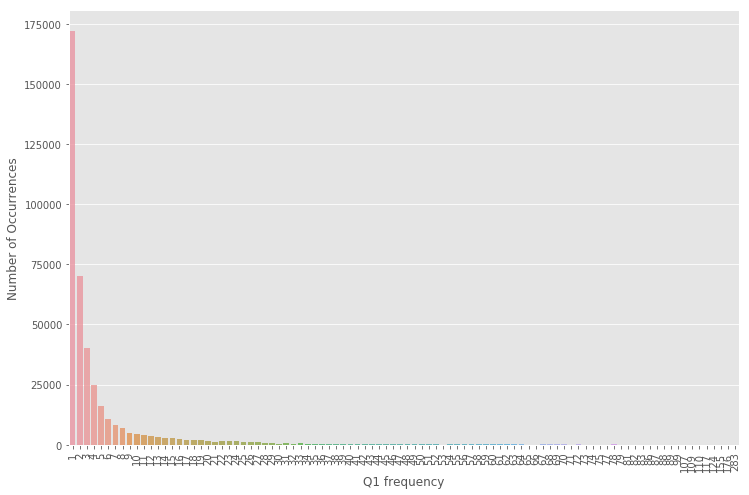

In [21]:
cnt_srs = train_df['q1_freq'].value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.xlabel('Q1 frequency', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

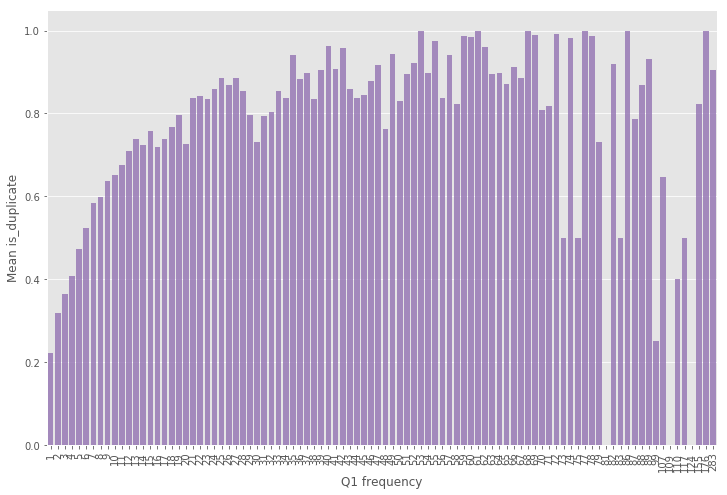

In [22]:
plt.figure(figsize=(12,8))
grouped_df = train_df.groupby('q1_freq')['is_duplicate'].aggregate(np.mean).reset_index()
sns.barplot(grouped_df["q1_freq"].values, grouped_df["is_duplicate"].values, alpha=0.8, color=color[4])
plt.ylabel('Mean is_duplicate', fontsize=12)
plt.xlabel('Q1 frequency', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
如果仅仅看question1被检索匹配的次数，会发现这个特征也很强，大致上也满足匹配次数越多，是同一个意义的可能性越高。但是没有之前联合交集的概率来的强。

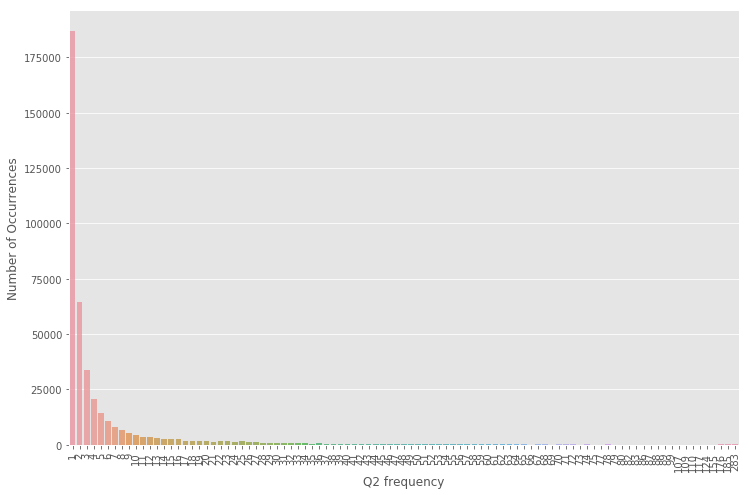

In [23]:
cnt_srs = train_df['q2_freq'].value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.xlabel('Q2 frequency', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

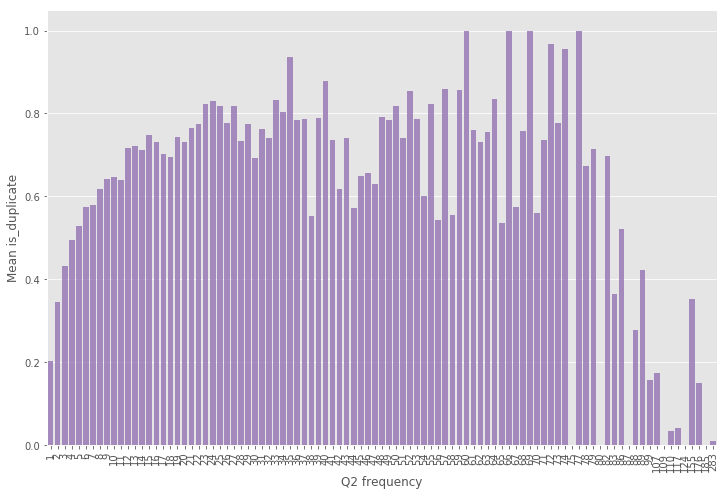

In [24]:
plt.figure(figsize=(12,8))
grouped_df = train_df.groupby('q2_freq')['is_duplicate'].aggregate(np.mean).reset_index()
sns.barplot(grouped_df["q2_freq"].values, grouped_df["is_duplicate"].values, alpha=0.8, color=color[4])
plt.ylabel('Mean is_duplicate', fontsize=12)
plt.xlabel('Q2 frequency', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

如果仅仅看question2被检索匹配的次数，会发现这个特征也很强，大致上也满足匹配次数越多，是同一个意义的可能性越高。

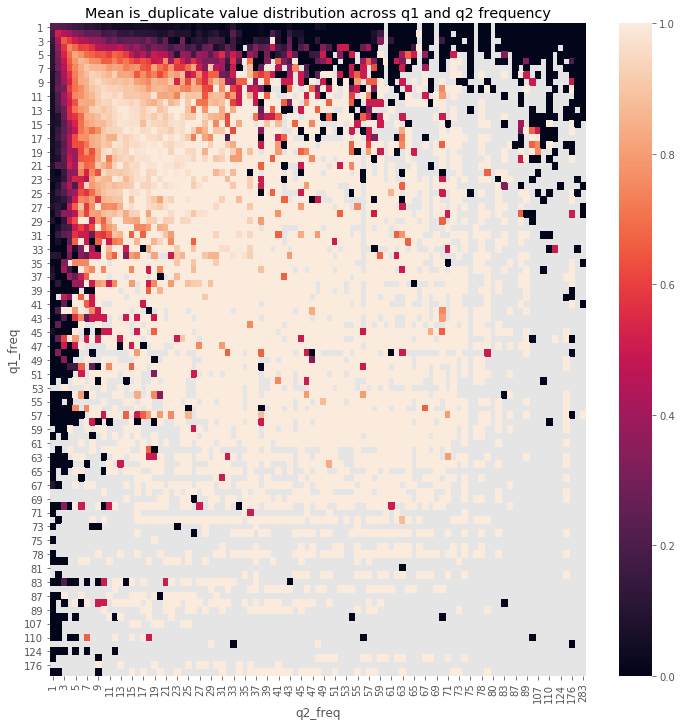

In [25]:
pvt_df = train_df.pivot_table(index="q1_freq", columns="q2_freq", values="is_duplicate")
plt.figure(figsize=(12,12))
sns.heatmap(pvt_df)
plt.title("Mean is_duplicate value distribution across q1 and q2 frequency")
plt.show()

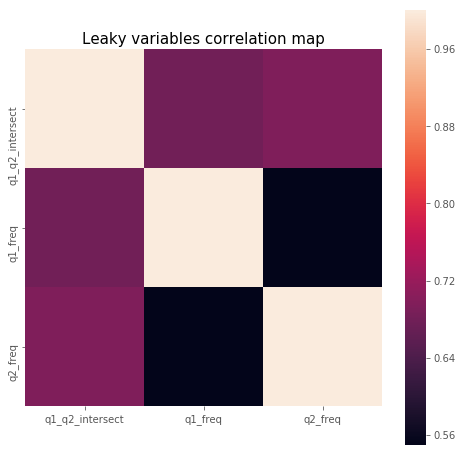

In [26]:
cols_to_use = ['q1_q2_intersect', 'q1_freq', 'q2_freq']
temp_df = train_df[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 8))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True)
plt.title("Leaky variables correlation map", fontsize=15)
plt.show()